# Pointwise lambda_B


In [1]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import models
from data_loader import DataLoader
import emcee, corner
from sklearn.covariance import EmpiricalCovariance
import numpy.linalg as lin
import seaborn as sns
from scipy.stats import truncnorm
from scipy.integrate import quad

In [2]:
# Which data to load?
# E_min : [0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 2.609, 3.586, 4.332, 5.475]
# E_max : [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 2.624, 3.598, 4.342, 5.484]
E_min = 0.676 # MeV
E_max = 2.624 # MeV
which_data = 'som'

# Select the parameterization
parameterization = 'bs_C'

# Use theory cov?
use_theory_cov = True

In [3]:
loader = DataLoader(E_min, E_max, which_data)

data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

############################################################################
############################################################################
# # # Trim the data
# # Set the fraction
# frac_keep = 0.25
# num_keep = int(frac_keep * data.shape[0])

# Set the number
num_keep = 293

indices_keep = np.linspace(0, data.shape[0] - 1, num_keep, dtype = int)
data = data[indices_keep]

# Unpack the data
E_lab = data[:, 0]
theta = data[:, 1]
cs_data = data[:, 2]
err_cs = data[:, 3]
print(data.shape)
norm_group = norm_group[indices_keep]
############################################################################
############################################################################


# # # Set the parameter bounds and initialize the model
if parameterization == 'standard':
    labels = ['A0', 'r0', 'A1+', 'r1+', 'P1+', 'A1-', 'r1-', 'P1-']
    sys.stderr.write('No Longer Supported....')
    sys.exit(-1)
elif parameterization == 'bound_state':
    labels = ['A0', 'r0', 'r1+', 'P1+', 'r1-', 'P1-']
    param_bounds = np.array([[-0.02, 0.06], [-3, 3], [-1, 1], [-6, 6], [-1, 1], [-6, 6]])
    params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [0.0, 0.1], [0.0, 1.6], [0.0, 0.1], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    sys.stderr.write('Not implemented yet...')
    sys.exit(-1)
elif parameterization == 'bs_C':
    labels = ['A0', 'r0', 'C1+^2', 'P1+', 'C1-^2', 'P1-']
    param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6]])
    params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = models.BS_C(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)
elif parameterization == 'init-f-wave':
    labels = ['A0', 'r0', 'C1+^2', 'P1+', 'C1-^2', 'P1-', 'r3+']
    param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6], [-3, 0]])
    params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6], [-0.5, 1]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = models.F_Wave_AR(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)

# Add normalization labels
for i in range(0, int(np.max(norm_group) + 1)):
    labels.append('f_{}'.format(i))

(293, 4)


In [4]:
# loader = DataLoader(E_min, E_max, which_data)

# data = loader.get_data()
# norm_group = loader.get_normalization_grouping()
# gauss_prior_f = loader.get_normalization_prior_info()

In [5]:
# gauss_prior_f

In [6]:
# Define the NLO function
def cs_theory_NLO(params):
        """
        This method utilizes the existence of a bound state and also the asymptotic normalization coefficients
        to compute the theoretical cross section at the energies and angles where we have data.

        NOTE: C1+/- is really (C1+/-)^2 since we are sampling C1 squared
        """
        # Extract the parameters from params
        A0, r0, C1plus, P1plus, C1minus, P1minus = params

        # Set parameters to 0
        r1minus = 0
        A0 = 0
        A1plus = 0
        A1minus = 0

        # Compute r1plus and r1minus based on the relation
        r1plus = np.real(-model.r1plus_val1 / C1plus + (P1plus * model.gamma1_plus**2) + (model.r1plus_val2) + (model.r1plus_val3))

        K_0 = (1 / (2 * model.kcvalue_cs)) * (-A0 + 0.5 * r0 * model.kvalue_cs**2)
        K_1_plus = (1 / (2 * model.kcvalue_cs**3)) * (-A1plus + 
                0.5 * r1plus * model.kvalue_cs**2 + 
                    0.25 * P1plus * model.kvalue_cs**4)
        K_1_minus = (1 / (2 * model.kcvalue_cs**3)) * (-A1minus + 
                0.5 * r1minus * model.kvalue_cs**2 + 
                    0.25 * P1minus * model.kvalue_cs**4)
        
        ERE_0 = (2 * model.kcvalue_cs * (K_0 - model.Hvalue_cs)) / model.C0_2value_cs
        ERE_1_plus = (2 * model.kcvalue_cs / (9 * model.C1_2value_cs)) * (
            model.kcvalue_cs**2 * K_1_plus - model.ERE1_val1)
        ERE_1_minus = (2 * model.kcvalue_cs / (9 * model.C1_2value_cs)) * (
            model.kcvalue_cs**2 * K_1_minus - model.ERE1_val1)

        # Compute the amplitude of each of the components
        # Rutherford - precomputed in __init__()
        
        # Coulomb
        f_c = model.f_r + (1 / ERE_0) + model.fc_val1 * (
            (2 / ERE_1_plus) + (1 / ERE_1_minus))

        # Interaction
        f_i = model.fi_val1 * ((1 / ERE_1_minus) - (1 / ERE_1_plus))

        sigma = 10 * (np.abs(f_c)**2 + np.abs(f_i)**2)
        sigma_R = 10 * np.abs(model.f_r)**2
        sigma_ratio = sigma / sigma_R
        return sigma_ratio

In [7]:
# Define the model parameters and norms
NLO_params = np.array([0.0, 0.8644, 15.0719, 1.9621, 0.0, 1.0163])
params = np.array([0.0115, 0.8644, 15.0719, 1.9621, 13.3486, 1.0163])
norms = np.array([0.9825, 0.9345, 1.0692, 1.0213, 1.0399, 1.0406, 1.0411])

# Define the values of the function at different orders
cs_LO = model.cs_LO_values
cs_NLO = cs_theory_NLO(NLO_params)
cs_N2LO = model.cs_theory(params)


In [8]:
# def get_Q(Lambda_B):
#     return model.Q_numerator / Lambda_B

# def get_c2(Lambda_B):
#     return (cs_N2LO - cs_NLO) / (cs_LO * np.square(get_Q(Lambda_B)))

# def nu(nu_0):
#     return nu_0 + 1

# def tau(tau_0, nu_0, c_2):
#     return np.sqrt((nu_0 * tau_0**2 + (np.square(c_2))) / nu(nu_0))

# # def prior(Lambda_B):
# #     # Trun norm , mu = 1.0, var = ~0.7
# #     return truncnorm(0.0, 3.0, loc = 1.0, scale = 0.7)
# #     # return np.exp(-np.square(Lambda_B - 1.0) / (2 * 0.7**2))

# def prior(Lambda_B):
#     return truncnorm.pdf(Lambda_B, -1.0 / 0.7, 4.0, loc = 1.0, scale = 0.7)

# def unnorm_prob(Lambda_B, tau_0, nu_0):
#     val = 1.0
#     for i in range(0, data.shape[0]):
#         val *= 1 / (((tau(tau_0, nu_0, get_c2(Lambda_B))[i]))**(nu(nu_0)) * get_Q(Lambda_B)[i]**2)
#     return prior(Lambda_B) * np.prod(val)

# def prob(tau_0, nu_0, Lambda_B):
#     A = quad(unnorm_prob, 0.0001, 5.0, args = (tau_0, nu_0))[0]
#     return 1 / A * unnorm_prob(Lambda_B, tau_0, nu_0)

In [9]:
# Lambda_Bs = np.linspace(0.01, 4, 200)
# probs = [prob(1.5, 1.5, i) for i in Lambda_Bs]
# priors = [prior(i) for i in Lambda_Bs]

In [10]:
# plt.style.use('bmh')

# plt.title('E_max = {} MeV'.format(E_max))
# plt.ylabel('\'Post\'')
# plt.xlabel('$\Lambda_{B}$')
# plt.plot(Lambda_Bs, probs, label = 'prob')
# plt.plot(Lambda_Bs, priors, label = 'prior')
# plt.legend()

In [11]:
# def get_Q(Lambda_B):
#     return model.Q_numerator / Lambda_B

# def get_c2(Lambda_B):
#     return (cs_N2LO - cs_NLO) / (cs_LO * np.square(get_Q(Lambda_B)))

# def nu(nu_0):
#     return nu_0 + 1

# def tau(tau_0, nu_0, c_2):
#     return np.sqrt((nu_0 * tau_0**2 + (np.square(c_2))) / nu(nu_0))

# # def prior(Lambda_B):
# #     # Trun norm , mu = 1.0, var = ~0.7
# #     return truncnorm(0.0, 3.0, loc = 1.0, scale = 0.7)
# #     # return np.exp(-np.square(Lambda_B - 1.0) / (2 * 0.7**2))

# def prior(Lambda_B):    
#     return np.where((Lambda_B >= 0) and (Lambda_B <= 4.0), 1 / (np.sqrt(2 * np.pi) * 0.7) * np.exp(-np.square((Lambda_B - 1.0) / (2 * 0.7**2))), 0)

# def unnorm_prob(Lambda_B, tau_0, nu_0):
#     val = 1.0
#     for i in range(0, data.shape[0]):
#         val *= 1 / (((tau(tau_0, nu_0, get_c2(Lambda_B))[i]))**(nu(nu_0)) * get_Q(Lambda_B)[i]**2)
#     return prior(Lambda_B) * np.prod(val)

# def exp_log_unnorm_prob(Lambda_B, tau_0, nu_0):
#     val = np.log(prior(Lambda_B))
#     taus = tau(tau_0, nu_0, get_c2(Lambda_B))
#     Qs = get_Q(Lambda_B)
#     for i in range(0, data.shape[0]):
#         val -= nu(nu_0) * np.log(taus[i]) + 2 * np.log(Qs[i])
#     return np.exp(val)

# def prob(tau_0, nu_0, Lambda_B):
#     A = quad(unnorm_prob, 0.0001, 5.0, args = (tau_0, nu_0))[0]
#     return 1 / A * unnorm_prob(Lambda_B, tau_0, nu_0)

# def exp_log_prob(tau_0, nu_0, Lambda_B):
#     A = quad(exp_log_unnorm_prob, 0.0001, 3.999, args = (tau_0, nu_0))[0]
#     return 1 / A * exp_log_unnorm_prob(Lambda_B, tau_0, nu_0)

In [12]:
# Lambda_Bs = np.linspace(0.01, 3.99, 200)
# probs = [exp_log_prob(1.5, 1.5, i) for i in Lambda_Bs]
# priors = [prior(i) for i in Lambda_Bs]

In [13]:
# plt.style.use('bmh')

# plt.title('E_max = {} MeV (Taking log)'.format(E_max))
# plt.ylabel('\'Post\'')
# plt.xlabel('$\Lambda_{B}$')
# plt.plot(Lambda_Bs, probs, label = 'prob')
# plt.plot(Lambda_Bs, priors, label = 'prior')
# plt.legend()

In [14]:
# print('hello')

# Also try with a uniform prior on lambda_B

------------------
## Using Wesolowski Eq. 12) - "curvewise"

$$P(Q | \vec{a}, I) \propto \frac{P(Q | I)}{\tau^{\nu} \prod_{n} Q^{N_{obs} n_{c}}}$$

$$\nu = \nu_{0} + N_{obs} n_{c}$$

$$\nu \tau^{2} = \nu_{0} \tau_{0}^{2} + \sum_{n, i} c_{n, i}^{2}$$

In [15]:
# Potential fix 1: Pull all the factors of Q algebraically inside tau 
# -> tau^nu \prod_i Q_i^3 =(Stuff)^N tau^nu_0

# Potential fix 2: Work in the log of the unnorm_prob, set lower threshold X so exp(X) = 0
# np.where(log_thing <= threshold, 0, np.exp(log_thing))

# Set global norm (inside the model in practice)
lambda_b_norm_scale = 0

def get_Q(Lambda_B):
    return model.Q_numerator / Lambda_B

def get_c2(Lambda_B):
    return (cs_N2LO - cs_NLO) / (cs_LO * np.square(get_Q(Lambda_B)))

def get_c_squared_sum(Lambda_B):
    c2s = (cs_N2LO - cs_NLO) / (cs_LO * np.square(get_Q(Lambda_B)))
    c1s = (cs_NLO - cs_LO) / (cs_LO * get_Q(Lambda_B))
    # c1s = 0
    return np.sum(np.square(c2s) + np.square(c1s))

def nu(nu_0):
    return nu_0 + (data.shape[0] * 2)
    # return nu_0 + (data.shape[0])


def tau(tau_0, nu_0, Lambda_B):
    return np.sqrt((nu_0 * tau_0**2 + get_c_squared_sum(Lambda_B)) / nu(nu_0))

def prior(Lambda_B):
    return np.where((Lambda_B >= 0) and (Lambda_B <= 4.0), 1 / (np.sqrt(2 * np.pi) * 0.7) * np.exp(-np.square((Lambda_B - 1.0) / (2 * 0.7**2))), 0)
    # return np.where((Lambda_B >= 0) and (Lambda_B <= 6.0), 1 / (np.sqrt(2 * np.pi) * 0.7) * np.exp(-np.square((Lambda_B - 1.0) / (2 * 0.7**2))), 0)
    # return 1.0

# def unnorm_prob(Lambda_B, tau_0, nu_0):
#     # TAKE THE LOG HERE - REVISE THIS
#     val = 1 / ((((tau(tau_0, nu_0, Lambda_B))))**(nu(nu_0)) * np.prod(np.power(get_Q(Lambda_B), 3)))
#     return prior(Lambda_B) * val

# def prob(tau_0, nu_0, Lambda_B):
#     A = quad(unnorm_prob, 0.0001, 5.0, args = (tau_0, nu_0))[0]
#     return 1 / A * unnorm_prob(Lambda_B, tau_0, nu_0)

def set_lambda_b_norm_scale(Lambda_Bs, tau_0, nu_0):
    vals = []
    for Lambda_B in Lambda_Bs:
        vals.append(np.log(prior(Lambda_B)) - nu(nu_0) * np.log(tau(tau_0, nu_0, Lambda_B)) - 3 * np.sum(np.log(get_Q(Lambda_B))))
    global lambda_b_norm_scale
    lambda_b_norm_scale = np.max(np.array(vals))

def exp_log_unnorm_prob(Lambda_B, tau_0, nu_0):
    val = np.log(prior(Lambda_B)) - nu(nu_0) * np.log(tau(tau_0, nu_0, Lambda_B)) - 3 * np.sum(np.log(get_Q(Lambda_B))) - lambda_b_norm_scale # Look into the normalization here with low N data
    # val = np.log(prior(Lambda_B)) - nu(nu_0) * np.log(tau(tau_0, nu_0, Lambda_B)) - 2 * np.sum(np.log(get_Q(Lambda_B))) - 1000
    return np.exp(val)

def exp_log_prob(tau_0, nu_0, Lambda_B):
    A = quad(exp_log_unnorm_prob, 0.0001, 3.999, args = (tau_0, nu_0))[0]
    return 1 / A * exp_log_unnorm_prob(Lambda_B, tau_0, nu_0)

In [16]:
Lambda_Bs = np.linspace(0.1, 4, 300)
set_lambda_b_norm_scale(Lambda_Bs, 1.5, 1.5)
print(lambda_b_norm_scale)
probs = [exp_log_prob(1.5, 1.5, i) for i in Lambda_Bs]
priors = [prior(i) for i in Lambda_Bs]

1038.7771044660872


In [17]:
# Lambda_Bs = np.linspace(0.1, 4, 300)
# probs = [exp_log_unnorm_prob(1.5, 1.5, i) for i in Lambda_Bs]
# priors = [prior(i) for i in Lambda_Bs]

# plt.plot(Lambda_Bs, probs)

In [18]:
print(Lambda_Bs[np.where(probs == max(probs))])

[0.90869565]


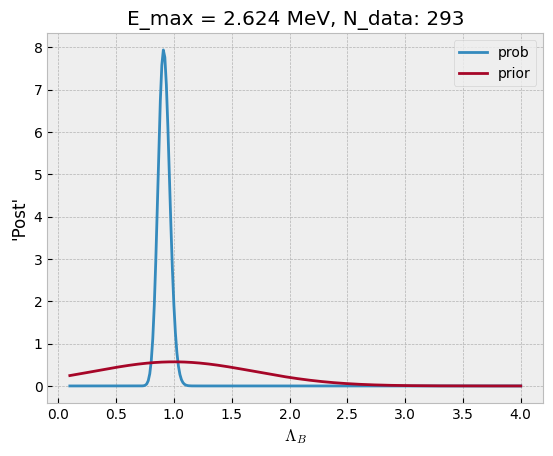

In [19]:
plt.style.use('bmh')

plt.title('E_max = {} MeV, N_data: {}'.format(E_max, E_lab.shape[0]))
plt.ylabel('\'Post\'')
plt.xlabel('$\Lambda_{B}$')
plt.plot(Lambda_Bs, probs, label = 'prob')
plt.plot(Lambda_Bs, priors, label = 'prior')
# plt.vlines(Lambda_Bs[np.where(probs == max(probs))], 0, max(probs) + 0.3, color = 'orange', label = '$\Lambda_B$ = {}'.format(Lambda_Bs[np.where(probs == max(probs))]))
plt.legend()

In [20]:
# cs_data.shape

In [21]:
# vals = [[], [], [], [], [], [], []]

# q = 2.0 * model.kvalue_cs * np.sin((model.theta_cs * np.pi / 180) / 2.0)
# k = model.kvalue_cs

# for i in range(0, cs_data.shape[0]):
#     vals[int(norm_group[i])].append([q[i].real, k[i].real])

In [22]:
# index = 2
# np.where(np.array(vals[index])[:, 0] < np.array(vals[index])[:, 1])

In [23]:
# q = 2.0 * model.kvalue_cs * np.sin((model.theta_cs * np.pi / 180) / 2.0)
# k = model.kvalue_cs
# q_or_p = np.where(q > k, 0, 1)

In [24]:
# # Set the value of tau_0
# tau_0 = 1.5

# # Obtain the MAP value of Lambda_B (Not sure if this is the right thing to do here...?)
# Lambda_B_MAP = Lambda_Bs[probs.index(max(probs))]

# # Use the MAP value to get the c_{i,k}s
# c2s = (cs_N2LO - cs_NLO) / (cs_LO * np.square(get_Q(Lambda_B_MAP)))
# c1s = (cs_NLO - cs_LO) / (cs_LO * get_Q(Lambda_B_MAP))

# # Get the c_tildes 
# c1_tilde = c1s / model.Q_numerator # model.Q_numerator is the max{q, k}
# c2_tilde = c2s / np.square(model.Q_numerator)

# # Get the rms values of the c_tildes
# c1_tilde_rms = np.mean(np.square(c1_tilde))
# c2_tilde_rms = np.mean(np.square(c2_tilde))

# print('c1~rms: {} \t c2~rms: {} \t tau_0: {}'.format(c1_tilde_rms, c2_tilde_rms, tau_0))

In [25]:
# index = 100
# nu_0 = 1.5
# tau_0 = 1.5


# val = lambda tau_0, nu_0, Lambda_B: np.log(prior(Lambda_B)) - nu(nu_0) * np.log(tau(tau_0, nu_0, Lambda_B)) - 3 * np.sum(np.log(get_Q(Lambda_B)))

# Lambda_Bs = np.linspace(0.01, 4, 200)
# probs = [val(1.5, 1.5, i) for i in Lambda_Bs]
# priors = [np.log(prior(i)) for i in Lambda_Bs]

# plt.style.use('bmh')

# plt.title('E_max = {} MeV'.format(E_max))
# plt.ylabel('\'Log (Unnormalized) Post\'')
# plt.xlabel('$\Lambda_{B}$')
# plt.plot(Lambda_Bs, probs, label = 'log unnorm post')
# plt.plot(Lambda_Bs, priors, label = 'log prior')
# plt.legend()

In [26]:
tau_0 = 1.5

# Get the values of y~s
y1_tilde = ((cs_NLO - cs_LO) / (cs_LO * model.Q_numerator)) # model.Q_numerator is the max{p, k}
y2_tilde = ((cs_N2LO - cs_NLO) / (cs_LO * np.square(model.Q_numerator)))

# Get the mean square values of the y~s
y1_tilde_ms = np.mean(np.square(y1_tilde))
y2_tilde_ms = np.mean(np.square(y2_tilde))

print('y1~ms: {} \t y2~ms: {} \t tau_0: {}'.format(y1_tilde_ms, y2_tilde_ms, tau_0))

y1~ms: 0.43139469477857795 	 y2~ms: 0.562293447429686 	 tau_0: 1.5


In [27]:
# # Set up the styles
# import seaborn as sns
# from matplotlib import colors as mcolors
# colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# plt.style.use('bmh')

# my_colors = [colors['dodgerblue'], colors['orange']]

# # # Set the plotting up
# fig, ax = plt.subplots(int(max(norm_group) + 1), 1, figsize=(6, 3 * int(max(norm_group) + 1)))

# q = 2.0 * model.kvalue_cs * np.sin((model.theta_cs * np.pi / 180) / 2.0)
# k = model.kvalue_cs
# q_or_k = np.where(q > k, 1, 0)

# for i in range(0, norm_group.shape[0]):
#     # scatter_y1 = ax[int(norm_group[i])].scatter(theta[i], y1_tilde[i], color = colors['dodgerblue'])
#     # scatter_y2 = ax[int(norm_group[i])].scatter(theta[i], y2_tilde[i], color = colors['orange'])
#     scatter_y1 = ax[int(norm_group[i])].scatter(theta[i], y1_tilde[i], color = my_colors[q_or_k[i]])
#     scatter_y2 = ax[int(norm_group[i])].scatter(theta[i], y2_tilde[i], color = my_colors[q_or_k[i]])

#     # # Set the label for the first point only
#     # if i == 0:
#     #     scatter_y1.set_label('$\\tilde{y}_{1}$')
#     #     scatter_y2.set_label('$\\tilde{y}_{2}$')

# # Creating a single legend outside the loop
# ax[0].legend()

# # List of energies for titles
# possible_Es = [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 2.624, 3.598, 4.342, 5.484]

# # Setup fig titles and axes labels
# for i in range(0, int(max(norm_group) + 1)):
#     ax[i].set_title('E = {} MeV'.format(possible_Es[i]))
#     ax[i].set_ylabel('$\\tilde{y}_{k} = \\frac{y_{k} - y_{k-1}}{y_{ref} p^{k}}$')
#     ax[i].set_xlabel('$\\theta [^{\circ}]$')

# plt.tight_layout()

In [28]:
# for j in plot_numbers:
#     for energy in l_som_energies[:, j]:
#         indices = np.where(data[:, 1] == energy)
#         tmp = data[indices]
#         ax[j].errorbar(tmp[:, 0], tmp[:, 2], yerr = tmp[:, 3], fmt = '.')

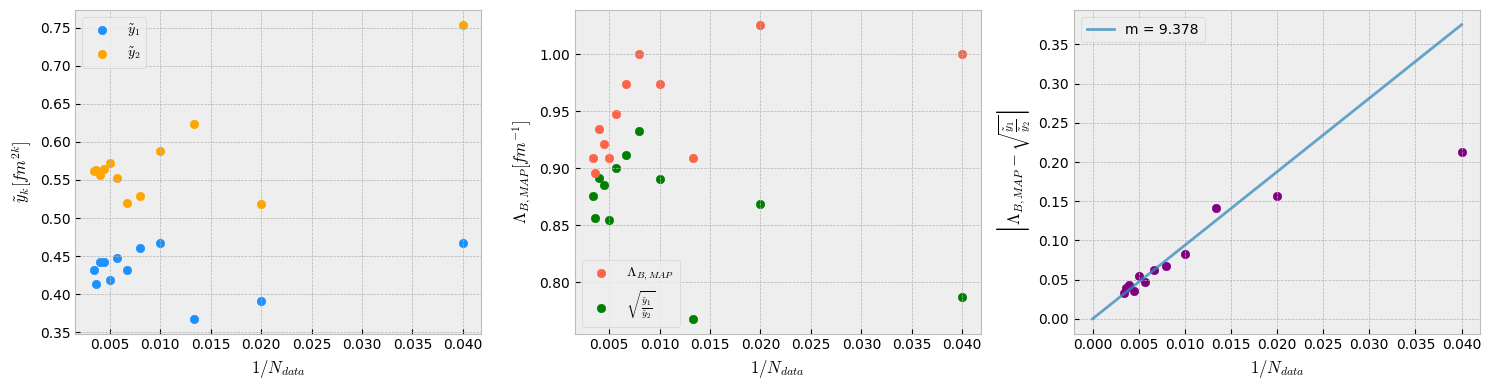

In [29]:
# Set up the styles
import seaborn as sns
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
plt.style.use('bmh')

my_colors = [colors['dodgerblue'], colors['orange']]


# N_data = [75, 100, 125, 150, 175, 200, 225, 250, 275, 293]
# y1_tildes = [0.36741687566408293, 0.46683450233408713, 0.46049776296233863, 0.43209873851223335, 0.44794665391592947, 0.4178869086095024, 0.44257152022774304, 0.44154943445256456, 0.4132545181349421, 0.43139469477857795]
# y2_tildes = [0.6232752276535749,  0.5885883139493496,  0.5293516012611055,  0.5202043206118677,  0.5525702189936083,  0.5722182302166087, 0.564090685725106,   0.555944340070213,   0.5636453699808608, 0.562293447429686]
# lambda_bs = [4.0,                 4.0,                 4.0, 4.0, 4.0, 4.0, 2.9695652173913043, 1.5347826086956522, 1.0913043478260869, 0.908695652173913]


N_data = np.array([25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 293])
y1_tildes = np.array([0.46742295891372143, 0.3911633871944553, 0.36741687566408293, 0.46683450233408713, 0.46049776296233863, 0.43209873851223335, 0.44794665391592947, 0.4178869086095024, 0.44257152022774304, 0.44154943445256456, 0.4132545181349421, 0.43139469477857795])
y2_tildes = np.array([0.7540824819960613,  0.5179162277852093, 0.6232752276535749,  0.5885883139493496,  0.5293516012611055,  0.5202043206118677,  0.5525702189936083,  0.5722182302166087, 0.564090685725106,   0.555944340070213,   0.5636453699808608, 0.562293447429686])
lambda_bs = np.array([0.9999999999999999,  1.0260869565217392, 0.908695652173913,   0.9739130434782608,  0.9999999999999999,  0.9739130434782608,  0.9478260869565217,  0.908695652173913,  0.9217391304347825,  0.9347826086956521,  0.8956521739130434, 0.908695652173913])

l_maps = np.sqrt(y1_tildes / y2_tildes)

fig, ax = plt.subplots(1, 3, figsize = (15,4))

# For plotting the line in the 3rd panel
n1 = 5
m = (np.abs(lambda_bs[n1] - l_maps[n1])) / (1 / N_data[n1])
x = np.linspace(0, 1 / N_data[0], 100)
thing = m * x

ax[2].plot(x, thing, alpha = 0.75, label = 'm = {:.3f}'.format(m))

for i in range(0, len(N_data)):
    scatter1 = ax[0].scatter((1 / N_data[i]), y1_tildes[i], color = my_colors[0])
    scatter2 = ax[0].scatter((1 / N_data[i]), y2_tildes[i], color = my_colors[1])
    scatter3 = ax[1].scatter((1 / N_data[i]), lambda_bs[i], color = colors['tomato'])
    scatter4 = ax[1].scatter((1 / N_data[i]), l_maps[i], color = colors['green'])
    ax[2].scatter((1 / N_data[i]), np.abs(l_maps[i] - lambda_bs[i]), color = colors['purple'])

    # scatter_y1 = ax[int(norm_group[i])].scatter(theta[i], y1_tilde[i], color = my_colors[q_or_k[i]])
    # scatter_y2 = ax[int(norm_group[i])].scatter(theta[i], y2_tilde[i], color = my_colors[q_or_k[i]])

    # Set the label for the first point only
    if i == 0:
        scatter1.set_label('$\\tilde{y}_{1}$')
        scatter2.set_label('$\\tilde{y}_{2}$')
        scatter3.set_label('$\Lambda_{B, MAP}$')
        scatter4.set_label('$\sqrt{ \\frac{\\tilde{y}_{1}}{\\tilde{y}_{2}}}$')



ax[0].set_xlabel('$1 / N_{data}$')
ax[0].set_ylabel('$\\tilde{y}_{k} [fm^{2k}]$')

ax[1].set_xlabel('$1 / N_{data}$')
ax[1].set_ylabel('$\Lambda_{B, MAP} [fm^{-1}]$')

ax[2].set_xlabel('$1 / N_{data}$')
ax[2].set_ylabel('$\left| \Lambda_{B,MAP} - \sqrt{ \\frac{\\tilde{y}_{1}}{\\tilde{y}_{2}}} \\right|$')

plt.tight_layout()

ax[0].legend()
ax[1].legend()
ax[2].legend()

In [30]:
print('y1~ms: {} \t y2~ms: {} \t Lambda_B: {}'.format(y1_tilde_ms, y2_tilde_ms, Lambda_Bs[np.where(probs == max(probs))][0]))

y1~ms: 0.43139469477857795 	 y2~ms: 0.562293447429686 	 Lambda_B: 0.908695652173913


In [36]:
model.cov_theory()[200, 10]

(0.001239806799837062+0j)

(0.001239806799837062+0j)